In [1]:
import numpy as np
import pandas as pd
from aif360.datasets import CompasDataset
from aif360.algorithms.preprocessing import Reweighing
from aif360.metrics import BinaryLabelDatasetMetric

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
2024-01-04 11:55:18.950801: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-04 11:55:18.950830: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-04 11:55:18.951465: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-04 11:55:18.955405: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical o

In [2]:
%matplotlib inline
# Load all necessary packages
# import sys
# sys.path.append("../")
import numpy as np
from tqdm import tqdm

from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
        import load_preproc_data_adult, load_preproc_data_german, load_preproc_data_compas
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from IPython.display import Markdown, display
import matplotlib.pyplot as plt

from common_utils import compute_metrics

## race as protected attribute logistic regression classifier

In [111]:
def custom_preprocessing(df):
    sex_mapping = {'Male': 1, 'Female': 0, 'Other': 2}
    df['sex'] = df['sex'].map(sex_mapping)

    race_mapping = {'African-American': 0, 'Caucasian': 1, 'Hispanic': 2, 'Other': 3, 'Asian': 4, 'Native American': 5}
    df['race'] = df['race'].map(race_mapping)

    return df

compas_data = CompasDataset(
    protected_attribute_names=['race', 'sex'],
    privileged_classes=[[1]],  
    custom_preprocessing=custom_preprocessing
)

privileged_groups = [{'race': 1}] 
unprivileged_groups = [{'race': 0}]

In [112]:
# Get the dataset and split into train and test
dataset_orig_train, dataset_orig_vt = compas_data.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = compas_data.split([0.3], shuffle=True)

#### Clean up training data

In [113]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.129076


In [114]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(dataset_orig_train)
dataset_transf_train = RW.transform(dataset_orig_train)

In [115]:
### Testing 
assert np.abs(dataset_transf_train.instance_weights.sum()-dataset_orig_train.instance_weights.sum())<1e-6

#### Metric with the transformed training data

In [116]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.000000


In [117]:
### Testing 
assert np.abs(metric_transf_train.mean_difference()) < 1e-6

### Train classifier on original data

In [118]:
# Logistic regression classifier and predictions
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()
w_train = dataset_orig_train.instance_weights.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train, 
         sample_weight=dataset_orig_train.instance_weights)
y_train_pred = lmod.predict(X_train)

# positive class index
pos_ind = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train.copy()
dataset_orig_train_pred.labels = y_train_pred

#### Obtain scores for original validation and test sets

In [119]:
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
X_valid = scale_orig.transform(dataset_orig_valid_pred.features)
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = lmod.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)
print(dataset_orig_valid_pred.scores[:10])

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

[[0.80032209]
 [0.3828227 ]
 [0.2900984 ]
 [0.16982953]
 [0.56142799]
 [0.70192142]
 [0.99868622]
 [0.50505098]
 [0.11031202]
 [0.40971008]]


### Find the optimal classification threshold from the validation set

In [120]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                             dataset_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no reweighing) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)

Best balanced accuracy (no reweighing) = 0.6861
Optimal classification threshold (no reweighing) = 0.5346


### Train classifier on transformed data

In [121]:
scale_transf = StandardScaler()
X_train = scale_transf.fit_transform(dataset_transf_train.features)
y_train = dataset_transf_train.labels.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train,
        sample_weight=dataset_transf_train.instance_weights)
y_train_pred = lmod.predict(X_train)

In [122]:
dataset_transf_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_transf.fit_transform(dataset_transf_test_pred.features)
y_test = dataset_transf_test_pred.labels
dataset_transf_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [131]:
privileged_groups_sex = [{'sex': 1}]  # Assuming 1 represents male
unprivileged_groups_sex = [{'sex': 0}]  # Assuming 0 represents female

display(Markdown("#### Predictions from transformed testing data"))
bal_acc_arr_transf = []
disp_imp_arr_transf = []
avg_odds_diff_arr_transf = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_transf_test_pred.scores > thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label
    
    metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_transf.append(metric_test_aft["Balanced accuracy"])
    avg_odds_diff_arr_transf.append(metric_test_aft["Average odds difference"])
    disp_imp_arr_transf.append(metric_test_aft["Disparate impact"])

# Calculate the maximum value for Balanced Accuracy
max_bal_acc = max(bal_acc_arr_transf)
max_bal_acc_index = bal_acc_arr_transf.index(max_bal_acc)

# Calculate the Average Odds Difference value closest to 0
min_avg_odds_diff = min(avg_odds_diff_arr_transf, key=lambda x: abs(x))
min_avg_odds_diff_index = avg_odds_diff_arr_transf.index(min_avg_odds_diff)

# Calculate the Disparate Impact value closest to 1
min_disp_impact_diff = min(disp_imp_arr_transf, key=lambda x: abs(x - 1))
min_disp_impact_diff_index = disp_imp_arr_transf.index(min_disp_impact_diff)

# Print the results
print(f"\nMaximum Balanced Accuracy: {max_bal_acc} (Threshold: {class_thresh_arr[max_bal_acc_index]})")
print(f"Average Odds Difference closest to 0: {min_avg_odds_diff} (Threshold: {class_thresh_arr[min_avg_odds_diff_index]})")
print(f"Disparate Impact closest to 1: {min_disp_impact_diff} (Threshold: {class_thresh_arr[min_disp_impact_diff_index]})")

#### Predictions from transformed testing data

Classification threshold used = 0.5346


100%|██████████| 100/100 [00:00<00:00, 274.89it/s]


Maximum Balanced Accuracy: 0.6936776182719673 (Threshold: 0.5643434343434344)
Average Odds Difference closest to 0: -0.00027011246443425785 (Threshold: 0.0198989898989899)
Disparate Impact closest to 1: 0.9952596958748702 (Threshold: 0.01)


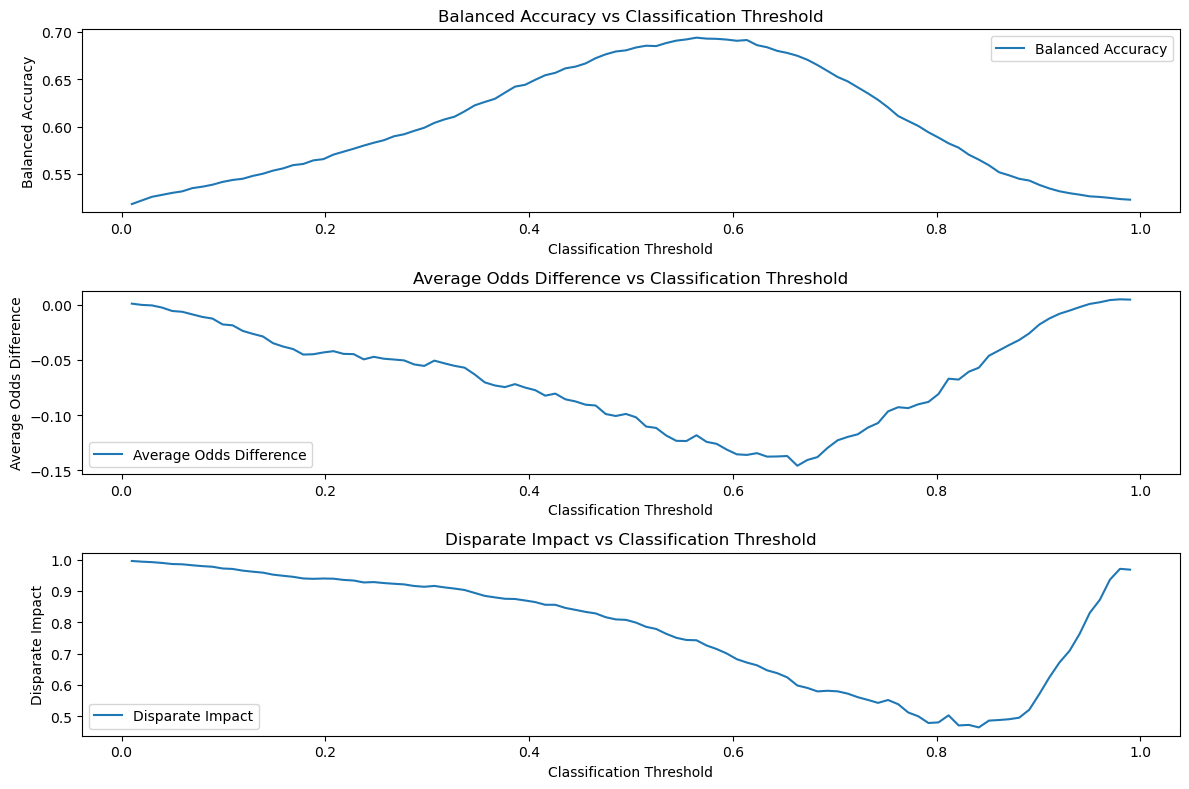

In [130]:
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(class_thresh_arr, bal_acc_arr_transf, label='Balanced Accuracy')
plt.xlabel('Classification Threshold')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy vs Classification Threshold')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(class_thresh_arr, avg_odds_diff_arr_transf, label='Average Odds Difference')
plt.xlabel('Classification Threshold')
plt.ylabel('Average Odds Difference')
plt.title('Average Odds Difference vs Classification Threshold')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(class_thresh_arr, disp_imp_arr_transf, label='Disparate Impact')
plt.xlabel('Classification Threshold')
plt.ylabel('Disparate Impact')
plt.title('Disparate Impact vs Classification Threshold')
plt.legend()

plt.tight_layout()
plt.show()

## Sex as protected attribute logistic regression classifier

In [132]:
def custom_preprocessing(df):
    sex_mapping = {'Male': 1, 'Female': 0, 'Other': 2}
    df['sex'] = df['sex'].map(sex_mapping)

    if 'race' in df.columns:
        df['race'] = pd.Categorical(df['race']).codes

    return df

compas_data = CompasDataset(
    protected_attribute_names=['sex', 'race'],
    privileged_classes=[[1]],  
    custom_preprocessing=custom_preprocessing
)

privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

In [133]:
# Get the dataset and split into train and test
dataset_orig_train, dataset_orig_vt = compas_data.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = compas_data.split([0.3], shuffle=True)

#### Clean up training data

In [134]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.135955


In [135]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(dataset_orig_train)
dataset_transf_train = RW.transform(dataset_orig_train)

In [136]:
### Testing 
assert np.abs(dataset_transf_train.instance_weights.sum()-dataset_orig_train.instance_weights.sum())<1e-6

#### Metric with the transformed training data

In [137]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.000000


In [138]:
### Testing 
assert np.abs(metric_transf_train.mean_difference()) < 1e-6

### Train classifier on original data

In [139]:
# Logistic regression classifier and predictions
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()
w_train = dataset_orig_train.instance_weights.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train, 
         sample_weight=dataset_orig_train.instance_weights)
y_train_pred = lmod.predict(X_train)

# positive class index
pos_ind = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train.copy()
dataset_orig_train_pred.labels = y_train_pred

#### Obtain scores for original validation and test sets

In [140]:
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
X_valid = scale_orig.transform(dataset_orig_valid_pred.features)
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = lmod.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)
print(dataset_orig_valid_pred.scores[:10])

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

[[0.80142605]
 [0.53995573]
 [0.26792066]
 [0.48827479]
 [0.51564081]
 [0.35145947]
 [0.60402546]
 [0.00130329]
 [0.89885296]
 [0.2057937 ]]


### Find the optimal classification threshold from the validation set

In [141]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                             dataset_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no reweighing) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)

Best balanced accuracy (no reweighing) = 0.6832
Optimal classification threshold (no reweighing) = 0.5346


### Predictions from the original test set at the optimal classification threshold

In [142]:
display(Markdown("#### Predictions from original testing data"))
bal_acc_arr_orig = []
disp_imp_arr_orig = []
avg_odds_diff_arr_orig = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_orig_test_pred.scores > thresh
    dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label
    
    metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])

#### Predictions from original testing data

Classification threshold used = 0.5346


100%|██████████| 100/100 [00:00<00:00, 295.60it/s]


### Train classifier on transformed data

In [143]:
scale_transf = StandardScaler()
X_train = scale_transf.fit_transform(dataset_transf_train.features)
y_train = dataset_transf_train.labels.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train,
        sample_weight=dataset_transf_train.instance_weights)
y_train_pred = lmod.predict(X_train)

In [144]:
dataset_transf_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_transf.fit_transform(dataset_transf_test_pred.features)
y_test = dataset_transf_test_pred.labels
dataset_transf_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [145]:
privileged_groups_sex = [{'race': 1}]  # Assuming 1 represents male
unprivileged_groups_sex = [{'race': 0}]  # Assuming 0 represents female

display(Markdown("#### Predictions from transformed testing data"))
bal_acc_arr_transf = []
disp_imp_arr_transf = []
avg_odds_diff_arr_transf = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_transf_test_pred.scores > thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label
    
    metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_transf.append(metric_test_aft["Balanced accuracy"])
    avg_odds_diff_arr_transf.append(metric_test_aft["Average odds difference"])
    disp_imp_arr_transf.append(metric_test_aft["Disparate impact"])


# Calculate the maximum value for Balanced Accuracy
max_bal_acc = max(bal_acc_arr_transf)
max_bal_acc_index = bal_acc_arr_transf.index(max_bal_acc)

# Calculate the Average Odds Difference value closest to 0
min_avg_odds_diff = min(avg_odds_diff_arr_transf, key=lambda x: abs(x))
min_avg_odds_diff_index = avg_odds_diff_arr_transf.index(min_avg_odds_diff)

# Calculate the Disparate Impact value closest to 1
min_disp_impact_diff = min(disp_imp_arr_transf, key=lambda x: abs(x - 1))
min_disp_impact_diff_index = disp_imp_arr_transf.index(min_disp_impact_diff)

# Print the results
print(f"\nMaximum Balanced Accuracy: {max_bal_acc} (Threshold: {class_thresh_arr[max_bal_acc_index]})")
print(f"Average Odds Difference closest to 0: {min_avg_odds_diff} (Threshold: {class_thresh_arr[min_avg_odds_diff_index]})")
print(f"Disparate Impact closest to 1: {min_disp_impact_diff} (Threshold: {class_thresh_arr[min_disp_impact_diff_index]})")

#### Predictions from transformed testing data

Classification threshold used = 0.5346


100%|██████████| 100/100 [00:00<00:00, 270.23it/s]


Maximum Balanced Accuracy: 0.68743415484224 (Threshold: 0.5247474747474747)
Average Odds Difference closest to 0: 8.002932340204529e-05 (Threshold: 0.8613131313131313)
Disparate Impact closest to 1: 1.000725350885287 (Threshold: 0.01)


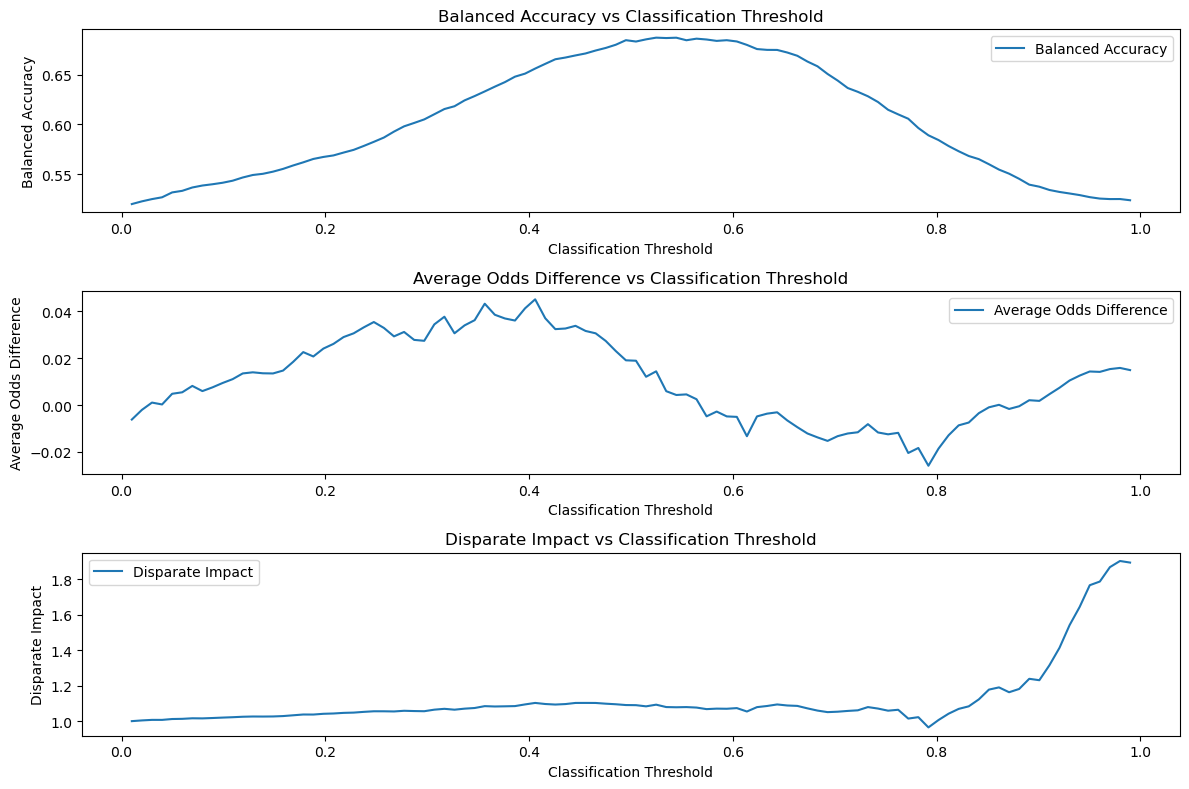

In [146]:
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(class_thresh_arr, bal_acc_arr_transf, label='Balanced Accuracy')
plt.xlabel('Classification Threshold')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy vs Classification Threshold')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(class_thresh_arr, avg_odds_diff_arr_transf, label='Average Odds Difference')
plt.xlabel('Classification Threshold')
plt.ylabel('Average Odds Difference')
plt.title('Average Odds Difference vs Classification Threshold')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(class_thresh_arr, disp_imp_arr_transf, label='Disparate Impact')
plt.xlabel('Classification Threshold')
plt.ylabel('Disparate Impact')
plt.title('Disparate Impact vs Classification Threshold')
plt.legend()

plt.tight_layout()
plt.show()

## Sex, race as protected attribute, age < 25, logistic regression classifier

In [30]:
# # Load the dataset with 'sex' and 'race' as protected attributes
# compas_data = CompasDataset(
#     protected_attribute_names=['sex', 'race'],
#     privileged_classes=[['Male'], ['Caucasian']],  # 'Male' for 'sex' and 'Caucasian' for 'race'
#     features_to_drop=[]  # No features to drop initially
# )

# # Filter the dataset for individuals aged less than 25
# compas_data = compas_data.subset(compas_data.features[:, compas_data.feature_names.index('age')] < 25)

# # Define privileged and unprivileged groups for both 'sex' and 'race'
# privileged_groups = [{'sex': 1, 'race': 1}]
# unprivileged_groups = [{'sex': 0, 'race': 0}]

In [31]:
def custom_preprocessing(df):
    sex_mapping = {'Male': 1, 'Female': 0, 'Other': 2}
    df['sex'] = df['sex'].map(sex_mapping)

    if 'race' in df.columns:
        race_mapping = {'African-American': 0, 'Caucasian': 1, 'Hispanic': 2, 'Other': 3, 'Asian': 4, 'Native American': 5}
        df['race'] = df['race'].map(race_mapping)

    return df

compas_data = CompasDataset(
    protected_attribute_names=['sex', 'race'],
    privileged_classes=[[1], [1]],  
    custom_preprocessing=custom_preprocessing
)

compas_data = compas_data.subset(compas_data.features[:, compas_data.feature_names.index('age')] < 25)

privileged_groups = [{'sex': 1, 'race': 1}]
unprivileged_groups = [{'sex': 0, 'race': 0}]

In [32]:
# Get the dataset and split into train and test
dataset_orig_train, dataset_orig_vt = compas_data.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = compas_data.split([0.3], shuffle=True)

#### Clean up training data

In [33]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.138357


In [34]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(dataset_orig_train)
dataset_transf_train = RW.transform(dataset_orig_train)

In [35]:
### Testing 
assert np.abs(dataset_transf_train.instance_weights.sum()-dataset_orig_train.instance_weights.sum())<1e-6

#### Metric with the transformed training data

In [36]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.000000


In [37]:
### Testing 
assert np.abs(metric_transf_train.mean_difference()) < 1e-6

### Train classifier on original data

In [38]:
# Logistic regression classifier and predictions
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()
w_train = dataset_orig_train.instance_weights.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train, 
         sample_weight=dataset_orig_train.instance_weights)
y_train_pred = lmod.predict(X_train)

# positive class index
pos_ind = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train.copy()
dataset_orig_train_pred.labels = y_train_pred

#### Obtain scores for original validation and test sets

In [39]:
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
X_valid = scale_orig.transform(dataset_orig_valid_pred.features)
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = lmod.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)
print(dataset_orig_valid_pred.scores[:10])

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

[[0.75640197]
 [0.78925315]
 [0.37499283]
 [0.38483366]
 [0.3540047 ]
 [0.60507324]
 [0.99783605]
 [0.1334959 ]
 [0.99765639]
 [0.47087553]]


### Find the optimal classification threshold from the validation set

In [40]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                             dataset_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no reweighing) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)

Best balanced accuracy (no reweighing) = 0.7145
Optimal classification threshold (no reweighing) = 0.3466


### Train classifier on transformed data

In [41]:
scale_transf = StandardScaler()
X_train = scale_transf.fit_transform(dataset_transf_train.features)
y_train = dataset_transf_train.labels.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train,
        sample_weight=dataset_transf_train.instance_weights)
y_train_pred = lmod.predict(X_train)

In [42]:
dataset_transf_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_transf.fit_transform(dataset_transf_test_pred.features)
y_test = dataset_transf_test_pred.labels
dataset_transf_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [43]:
display(Markdown("#### Predictions from transformed testing data"))
bal_acc_arr_transf = []
disp_imp_arr_transf = []
avg_odds_diff_arr_transf = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_transf_test_pred.scores > thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label
    
    metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_transf.append(metric_test_aft["Balanced accuracy"])
    avg_odds_diff_arr_transf.append(metric_test_aft["Average odds difference"])
    disp_imp_arr_transf.append(metric_test_aft["Disparate impact"])

#### Predictions from transformed testing data

Classification threshold used = 0.3466


100%|██████████| 100/100 [00:00<00:00, 768.88it/s]

Balanced accuracy = 0.6871
Statistical parity difference = 0.2022
Disparate impact = 1.3099
Average odds difference = 0.1518
Equal opportunity difference = 0.1249
Theil index = 0.1256


## Sex, race as protected attribute, 25 < age < 45, logistic regression classifier

In [44]:
# # Load the dataset with 'sex' and 'race' as protected attributes
# compas_data = CompasDataset(
#     protected_attribute_names=['sex', 'race'],
#     privileged_classes=[['Male'], ['Caucasian']],  # 'Male' for 'sex' and 'Caucasian' for 'race'
#     features_to_drop=[]  # No features to drop initially
# )

# # Filter the dataset for individuals aged less than 25
# compas_data = compas_data.subset(compas_data.features[:, compas_data.feature_names.index('age')] > 25)

# # Define privileged and unprivileged groups for both 'sex' and 'race'
# privileged_groups = [{'sex': 1, 'race': 1}]
# unprivileged_groups = [{'sex': 0, 'race': 0}]

In [45]:
def custom_preprocessing(df):
    sex_mapping = {'Male': 1, 'Female': 0, 'Other': 2}
    df['sex'] = df['sex'].map(sex_mapping)

    if 'race' in df.columns:
        race_mapping = {'African-American': 0, 'Caucasian': 1, 'Hispanic': 2, 'Other': 3, 'Asian': 4, 'Native American': 5}
        df['race'] = df['race'].map(race_mapping)

    return df

compas_data = CompasDataset(
    protected_attribute_names=['sex', 'race'],
    privileged_classes=[[1], [1]],  
    custom_preprocessing=custom_preprocessing
)

age_index = compas_data.feature_names.index('age')

compas_data = compas_data.subset((compas_data.features[:, age_index] > 25) & (compas_data.features[:, age_index] < 45))

privileged_groups = [{'sex': 1, 'race': 1}]
unprivileged_groups = [{'sex': 0, 'race': 0}]

In [46]:
# Get the dataset and split into train and test
dataset_orig_train, dataset_orig_vt = compas_data.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = compas_data.split([0.3], shuffle=True)

#### Clean up training data

In [47]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.067310


In [48]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(dataset_orig_train)
dataset_transf_train = RW.transform(dataset_orig_train)

In [49]:
### Testing 
assert np.abs(dataset_transf_train.instance_weights.sum()-dataset_orig_train.instance_weights.sum())<1e-6

#### Metric with the transformed training data

In [50]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.000000


In [51]:
### Testing 
assert np.abs(metric_transf_train.mean_difference()) < 1e-6

### Train classifier on original data

In [52]:
# Logistic regression classifier and predictions
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()
w_train = dataset_orig_train.instance_weights.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train, 
         sample_weight=dataset_orig_train.instance_weights)
y_train_pred = lmod.predict(X_train)

# positive class index
pos_ind = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train.copy()
dataset_orig_train_pred.labels = y_train_pred

#### Obtain scores for original validation and test sets

In [53]:
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
X_valid = scale_orig.transform(dataset_orig_valid_pred.features)
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = lmod.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)
print(dataset_orig_valid_pred.scores[:10])

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

[[0.46372328]
 [0.64174296]
 [0.42553188]
 [0.79302341]
 [0.58406492]
 [0.15746026]
 [0.65195472]
 [0.55623218]
 [0.52518016]
 [0.8096191 ]]


### Find the optimal classification threshold from the validation set

In [54]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                             dataset_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no reweighing) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)

Best balanced accuracy (no reweighing) = 0.6942
Optimal classification threshold (no reweighing) = 0.5742


### Predictions from the original test set at the optimal classification threshold

In [55]:
display(Markdown("#### Predictions from original testing data"))
bal_acc_arr_orig = []
disp_imp_arr_orig = []
avg_odds_diff_arr_orig = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_orig_test_pred.scores > thresh
    dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label
    
    metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])

#### Predictions from original testing data

Classification threshold used = 0.5742


 49%|████▉     | 49/100 [00:00<00:00, 480.47it/s]

Balanced accuracy = 0.6963
Statistical parity difference = -0.0034
Disparate impact = 0.9946
Average odds difference = -0.0317
Equal opportunity difference = 0.0028
Theil index = 0.2025


100%|██████████| 100/100 [00:00<00:00, 483.71it/s]


### Train classifier on transformed data

In [56]:
scale_transf = StandardScaler()
X_train = scale_transf.fit_transform(dataset_transf_train.features)
y_train = dataset_transf_train.labels.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train,
        sample_weight=dataset_transf_train.instance_weights)
y_train_pred = lmod.predict(X_train)

In [57]:
dataset_transf_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_transf.fit_transform(dataset_transf_test_pred.features)
y_test = dataset_transf_test_pred.labels
dataset_transf_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [58]:
display(Markdown("#### Predictions from transformed testing data"))
bal_acc_arr_transf = []
disp_imp_arr_transf = []
avg_odds_diff_arr_transf = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_transf_test_pred.scores > thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label
    
    metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_transf.append(metric_test_aft["Balanced accuracy"])
    avg_odds_diff_arr_transf.append(metric_test_aft["Average odds difference"])
    disp_imp_arr_transf.append(metric_test_aft["Disparate impact"])

#### Predictions from transformed testing data

Classification threshold used = 0.5742


 36%|███▌      | 36/100 [00:00<00:00, 352.76it/s]

Balanced accuracy = 0.6981
Statistical parity difference = -0.0909
Disparate impact = 0.8546
Average odds difference = -0.1233
Equal opportunity difference = -0.0769
Theil index = 0.2162


100%|██████████| 100/100 [00:00<00:00, 414.25it/s]


## Sex, race as protected attribute, age > 45, logistic regression classifier

In [59]:
def custom_preprocessing(df):
    sex_mapping = {'Male': 1, 'Female': 0, 'Other': 2}
    df['sex'] = df['sex'].map(sex_mapping)

    if 'race' in df.columns:
        race_mapping = {'African-American': 0, 'Caucasian': 1, 'Hispanic': 2, 'Other': 3, 'Asian': 4, 'Native American': 5}
        df['race'] = df['race'].map(race_mapping)

    return df

compas_data = CompasDataset(
    protected_attribute_names=['sex', 'race'],
    privileged_classes=[[1], [1]],  
    custom_preprocessing=custom_preprocessing
)

age_index = compas_data.feature_names.index('age')

compas_data = compas_data.subset(compas_data.features[:, age_index] > 45)

privileged_groups = [{'sex': 1, 'race': 1}]
unprivileged_groups = [{'sex': 0, 'race': 0}]

In [60]:
# Get the dataset and split into train and test
dataset_orig_train, dataset_orig_vt = compas_data.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = compas_data.split([0.3], shuffle=True)

#### Clean up training data

In [61]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.123031


In [62]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(dataset_orig_train)
dataset_transf_train = RW.transform(dataset_orig_train)

In [63]:
### Testing 
assert np.abs(dataset_transf_train.instance_weights.sum()-dataset_orig_train.instance_weights.sum())<1e-6

#### Metric with the transformed training data

In [64]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.000000


In [65]:
### Testing 
assert np.abs(metric_transf_train.mean_difference()) < 1e-6

### Train classifier on original data

In [66]:
# Logistic regression classifier and predictions
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()
w_train = dataset_orig_train.instance_weights.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train, 
         sample_weight=dataset_orig_train.instance_weights)
y_train_pred = lmod.predict(X_train)

# positive class index
pos_ind = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train.copy()
dataset_orig_train_pred.labels = y_train_pred

#### Obtain scores for original validation and test sets

In [67]:
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
X_valid = scale_orig.transform(dataset_orig_valid_pred.features)
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = lmod.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)
print(dataset_orig_valid_pred.scores[:10])

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

[[0.47047729]
 [0.67595835]
 [0.54178347]
 [0.73913048]
 [0.64432559]
 [0.88286706]
 [0.01380325]
 [0.62843736]
 [0.53091768]
 [0.4846105 ]]


### Find the optimal classification threshold from the validation set

In [68]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                             dataset_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no reweighing) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)

Best balanced accuracy (no reweighing) = 0.7404
Optimal classification threshold (no reweighing) = 0.6039


### Predictions from the original test set at the optimal classification threshold

In [69]:
display(Markdown("#### Predictions from original testing data"))
bal_acc_arr_orig = []
disp_imp_arr_orig = []
avg_odds_diff_arr_orig = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_orig_test_pred.scores > thresh
    dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label
    
    metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])

#### Predictions from original testing data

Classification threshold used = 0.6039


100%|██████████| 100/100 [00:00<00:00, 1017.04it/s]

Balanced accuracy = 0.7004
Statistical parity difference = 0.0989
Disparate impact = 1.1283
Average odds difference = 0.0637
Equal opportunity difference = 0.0726
Theil index = 0.1455


### Train classifier on transformed data

In [70]:
scale_transf = StandardScaler()
X_train = scale_transf.fit_transform(dataset_transf_train.features)
y_train = dataset_transf_train.labels.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train,
        sample_weight=dataset_transf_train.instance_weights)
y_train_pred = lmod.predict(X_train)

In [71]:
dataset_transf_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_transf.fit_transform(dataset_transf_test_pred.features)
y_test = dataset_transf_test_pred.labels
dataset_transf_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [72]:
display(Markdown("#### Predictions from transformed testing data"))
bal_acc_arr_transf = []
disp_imp_arr_transf = []
avg_odds_diff_arr_transf = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_transf_test_pred.scores > thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label
    
    metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_transf.append(metric_test_aft["Balanced accuracy"])
    avg_odds_diff_arr_transf.append(metric_test_aft["Average odds difference"])
    disp_imp_arr_transf.append(metric_test_aft["Disparate impact"])

#### Predictions from transformed testing data

Classification threshold used = 0.6039


 69%|██████▉   | 69/100 [00:00<00:00, 682.95it/s]

Balanced accuracy = 0.7018
Statistical parity difference = 0.0908
Disparate impact = 1.1193
Average odds difference = 0.0649
Equal opportunity difference = 0.0566
Theil index = 0.1526


100%|██████████| 100/100 [00:00<00:00, 750.68it/s]
